In [69]:
import h5py
import numpy as np
import os,random
from tensorflow.keras.layers import Input,Reshape,ZeroPadding2D,Conv2D,Dropout,Flatten,Dense,Activation,MaxPooling2D,AlphaDropout
from tensorflow.keras import layers
import tensorflow.keras.models as Model
from tensorflow.keras.regularizers import *
from tensorflow.keras.optimizers import Adam
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model

In [57]:
f = h5py.File('ExtractDataset/part0.h5')
sample_num = f['X'].shape[0]
idx = np.random.choice(range(0,sample_num),size=60000)
# idx = np.random.choice(range(0,sample_num),size=30000)
X = f['X'][:][idx]
Y = f['Y'][:][idx]
Z = f['Z'][:][idx]
f.close()

for i in range(1,24):
    if i%1 == 0:
        !free -m
    '''if i == 10:
        continue'''
    filename = 'ExtractDataset/part'+str(i) + '.h5'
    print(filename)
    f = h5py.File(filename,'r')
    X = np.vstack((X,f['X'][:][idx]))
    Y = np.vstack((Y,f['Y'][:][idx]))
    Z = np.vstack((Z,f['Z'][:][idx]))
    f.close()


print('X-size：',X.shape)
print('Y-size：',Y.shape)
print('Z-size：',Z.shape)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  """Entry point for launching an IPython kernel.


              total        used        free      shared  buff/cache   available
Mem:          64362       16502       40316          89        7542       47242
Swap:           976         898          78
ExtractDataset/part1.h5
              total        used        free      shared  buff/cache   available
Mem:          64362       16974       39844          89        7542       46770
Swap:           976         898          78
ExtractDataset/part2.h5
              total        used        free      shared  buff/cache   available
Mem:          64362       17447       39371          89        7542       46297
Swap:           976         898          78
ExtractDataset/part3.h5
              total        used        free      shared  buff/cache   available
Mem:          64362       17914       38905          89        7542       45830
Swap:           976         898          78
ExtractDataset/part4.h5
              total        used        free      shared  buff/cache   available
Mem:    

## Data preprocessing, and obtain training set and test set

In [60]:
n_examples = X.shape[0]
n_train = int(n_examples * 0.8)   
train_idx = np.random.choice(range(0,n_examples), size=n_train, replace=False)  #Randomly select training sample subscript
test_idx = list(set(range(0,n_examples))-set(train_idx)) #Test sample index
X_train = X[train_idx]  #training samples
X_test =  X[test_idx]  #testing samples
Y_train = Y[train_idx]
Y_test = Y[test_idx]
print("X_train:",X_train.shape)
print("Y_train:",Y_train.shape)
print("X_test:",X_test.shape)
print("Y_test:",Y_test.shape)

X_train: (1152000, 1024, 2)
Y_train: (1152000, 24)
X_test: (288000, 1024, 2)
Y_test: (288000, 24)


In [64]:
classes = ['32PSK',
 '16APSK',
 '32QAM',
 'FM',
 'GMSK',
 '32APSK',
 'OQPSK',
 '8ASK',
 'BPSK',
 '8PSK',
 'AM-SSB-SC',
 '4ASK',
 '16PSK',
 '64APSK',
 '128QAM',
 '128APSK',
 'AM-DSB-SC',
 'AM-SSB-WC',
 '64QAM',
 'QPSK',
 '256QAM',
 'AM-DSB-WC',
 'OOK',
 '16QAM']

def residual_stack(X,Filters,Seq,max_pool):
    #1*1 Conv Linear
    X = Conv2D(Filters, (1, 1), padding='same', name=Seq+"_conv1", kernel_initializer='glorot_uniform',data_format="channels_first")(X)
    #Residual Unit 1
    X_shortcut = X
    X = Conv2D(Filters, (3, 2), padding='same',activation="relu",name=Seq+"_conv2", kernel_initializer='glorot_uniform',data_format="channels_first")(X)
    X = Conv2D(Filters, (3, 2), padding='same', name=Seq+"_conv3", kernel_initializer='glorot_uniform',data_format="channels_first")(X)
    X = layers.add([X,X_shortcut])
    X = Activation("relu")(X)
    #Residual Unit 2
    X_shortcut = X
    X = Conv2D(Filters, (3, 2), padding='same',activation="relu",name=Seq+"_conv4", kernel_initializer='glorot_uniform',data_format="channels_first")(X)
    X = Conv2D(Filters, (3, 2), padding='same', name=Seq+"_conv5", kernel_initializer='glorot_uniform',data_format="channels_first")(X)
    X = layers.add([X,X_shortcut])
    X = Activation("relu")(X)
    #MaxPooling
    if max_pool:
        X = MaxPooling2D(pool_size=(2, 1), strides=(2, 1), padding='valid', data_format="channels_first")(X)
    return X


in_shp = X_train.shape[1:]   #Dimensions of each sample
#input layer
X_input = Input(in_shp)
X = Reshape([1,1024,2], input_shape=in_shp)(X_input)
#Residual Srack 1
X = residual_stack(X,32,"ReStk1",False)  #shape:(1,512,32)
X = MaxPooling2D(pool_size=(2, 2), strides=(2, 1), padding='valid', data_format="channels_first")(X)
#Residual Srack 2
X = residual_stack(X,32,"ReStk2",True)  #shape:(1,256,32)
#Residual Srack 3
X = residual_stack(X,32,"ReStk3",True)  #shape:(1,128,32)
#Residual Srack 4
X = residual_stack(X,32,"ReStk4",True)  #shape:(1,64,32)
#Residual Srack 5
X = residual_stack(X,32,"ReStk5",True)  #shape:(1,32,32)
#Residual Srack 6
X = residual_stack(X,32,"ReStk6",True)  #shape:(1,16,32)
#Full Con 1
X = Flatten()(X)
X = Dense(128, activation='selu', kernel_initializer='he_normal', name="dense1")(X)
X = AlphaDropout(0.3)(X)
#Full Con 2
X = Dense(128, activation='selu', kernel_initializer='he_normal', name="dense2")(X)
X = AlphaDropout(0.3)(X)
#Full Con 3
X = Dense(len(classes), kernel_initializer='he_normal', name="dense3")(X)
#SoftMax
X = Activation('softmax')(X)
#Create Model
model = Model.Model(inputs=X_input,outputs=X)
model.compile(loss='categorical_crossentropy', optimizer='adam',metrics=['accuracy'])
model.summary()

Model: "functional_9"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            [(None, 1024, 2)]    0                                            
__________________________________________________________________________________________________
reshape_5 (Reshape)             (None, 1, 1024, 2)   0           input_6[0][0]                    
__________________________________________________________________________________________________
ReStk1_conv1 (Conv2D)           (None, 32, 1024, 2)  64          reshape_5[0][0]                  
__________________________________________________________________________________________________
ReStk1_conv2 (Conv2D)           (None, 32, 1024, 2)  6176        ReStk1_conv1[0][0]               
_______________________________________________________________________________________

In [62]:
# perform training ...
#   - call the main training loop in keras for our network+dataset
print(tf.test.gpu_device_name())

/device:GPU:0


In [63]:
mirrored_strategy = tf.distribute.MirroredStrategy(devices=["/gpu:0","/gpu:1","/gpu:2"], cross_device_ops=tf.distribute.HierarchicalCopyAllReduce())

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1', '/job:localhost/replica:0/task:0/device:GPU:2')


In [65]:

filepath = 'resnet_model.h5'
history = model.fit(X_train,
    Y_train,
    batch_size=1024,
    epochs=100,
    verbose=1,
#     validation_data=(X_test, Y_test),
    validation_split = 0.2,
    callbacks = [
        tf.keras.callbacks.ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='auto'),
        tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, verbose=1, mode='auto')
    ])

Epoch 1/100
900/900 [==============================] - ETA: 0s - loss: 2.2344 - accuracy: 0.2410WARNING:tensorflow:Callbacks method `on_test_batch_end` is slow compared to the batch time (batch time: 0.0047s vs `on_test_batch_end` time: 0.0431s). Check your callbacks.

Epoch 00001: val_loss improved from inf to 1.86499, saving model to resnet_model.h5
900/900 [==============================] - 165s 183ms/step - loss: 2.2344 - accuracy: 0.2410 - val_loss: 1.8650 - val_accuracy: 0.3370
Epoch 2/100
900/900 [==============================] - ETA: 0s - loss: 1.9181 - accuracy: 0.3309
Epoch 00002: val_loss did not improve from 1.86499
900/900 [==============================] - 169s 188ms/step - loss: 1.9181 - accuracy: 0.3309 - val_loss: 2.4974 - val_accuracy: 0.1768
Epoch 3/100
900/900 [==============================] - ETA: 0s - loss: 1.9399 - accuracy: 0.3215
Epoch 00003: val_loss improved from 1.86499 to 1.80219, saving model to resnet_model.h5
900/900 [==============================] - 

Epoch 27/100
900/900 [==============================] - ETA: 0s - loss: 1.2651 - accuracy: 0.5723
Epoch 00027: val_loss improved from 1.28999 to 1.28537, saving model to resnet_model.h5
900/900 [==============================] - 175s 195ms/step - loss: 1.2651 - accuracy: 0.5723 - val_loss: 1.2854 - val_accuracy: 0.5709
Epoch 28/100
900/900 [==============================] - ETA: 0s - loss: 1.2642 - accuracy: 0.5735
Epoch 00028: val_loss improved from 1.28537 to 1.28378, saving model to resnet_model.h5
900/900 [==============================] - 175s 195ms/step - loss: 1.2642 - accuracy: 0.5735 - val_loss: 1.2838 - val_accuracy: 0.5738
Epoch 29/100
900/900 [==============================] - ETA: 0s - loss: 1.2641 - accuracy: 0.5739
Epoch 00029: val_loss did not improve from 1.28378
900/900 [==============================] - 176s 196ms/step - loss: 1.2641 - accuracy: 0.5739 - val_loss: 1.2925 - val_accuracy: 0.5728
Epoch 30/100
900/900 [==============================] - ETA: 0s - loss: 1.

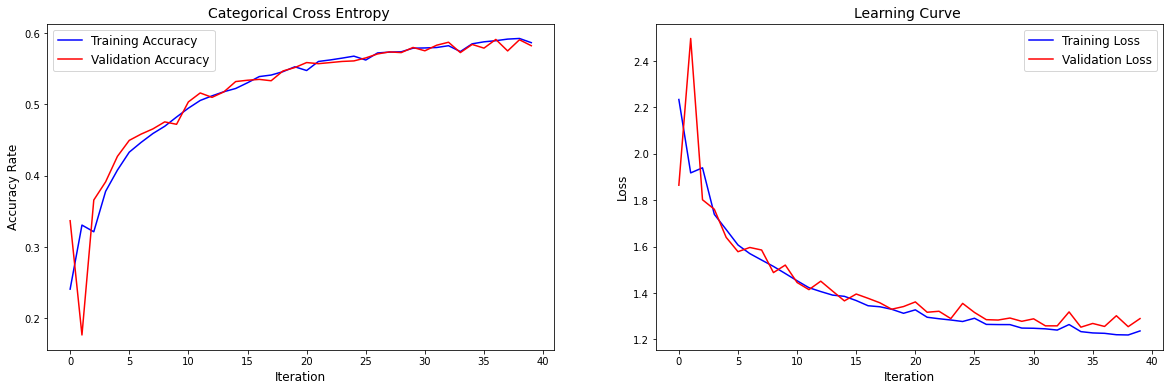

In [76]:
fig, ((ax1, ax2)) = plt.subplots(nrows=1, ncols=2,figsize=(20,6))

ax1.plot(history.history['accuracy'],'b', history.history['val_accuracy'], 'r')
ax1.set_ylabel('Accuracy Rate',fontsize=12)
ax1.set_xlabel('Iteration',fontsize=12)
ax1.set_title('Categorical Cross Entropy ',fontsize=14)
ax1.legend(['Training Accuracy','Validation Accuracy'],fontsize=12,loc='best')

ax2.plot(history.history['loss'], 'b',history.history['val_loss'],'r')
ax2.set_ylabel('Loss',fontsize=12)
ax2.set_xlabel('Iteration',fontsize=12)
ax2.set_title('Learning Curve ',fontsize=14)
ax2.legend(['Training Loss','Validation Loss'],fontsize=12,loc='best')

# plt.savefig('crosse_results.png')
plt.show()

In [77]:
model = load_model(filepath)

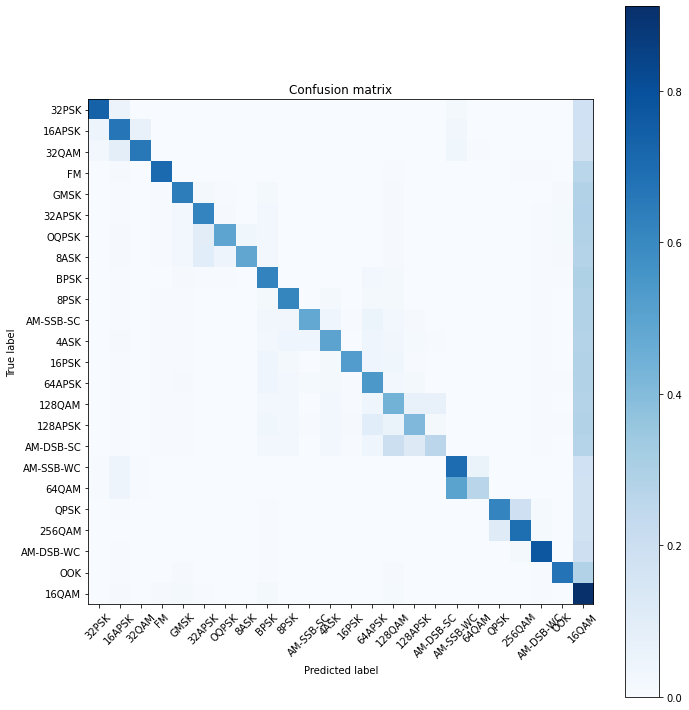

In [78]:
def plot_confusion_matrix(cm, title='Confusion matrix', cmap=plt.cm.Blues, labels=[]):
    plt.figure(figsize=(10, 10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(labels))
    plt.xticks(tick_marks, labels, rotation=45)
    plt.yticks(tick_marks, labels)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
# Plot confusion matrix
batch_size = 1024
test_Y_hat = model.predict(X_test, batch_size=3000)
conf = np.zeros([len(classes),len(classes)])
confnorm = np.zeros([len(classes),len(classes)])
for i in range(0,X_test.shape[0]):
    j = list(Y_test[i,:]).index(1)
    k = int(np.argmax(test_Y_hat[i,:]))
    conf[j,k] = conf[j,k] + 1
for i in range(0,len(classes)):
    confnorm[i,:] = conf[i,:] / np.sum(conf[i,:])
plot_confusion_matrix(confnorm, labels=classes)

In [79]:
for i in range(len(confnorm)):
    print(classes[i],confnorm[i,i])

32PSK 0.7363333333333333
16APSK 0.6660308508873777
32QAM 0.6552210334245666
FM 0.7064883276563928
GMSK 0.6385259631490787
32APSK 0.6132482175426961
OQPSK 0.4944843723884339
8ASK 0.48512623948004335
BPSK 0.6181787606154882
8PSK 0.6111480312344243
AM-SSB-SC 0.48000999500249875
4ASK 0.4967853610286845
16PSK 0.5249834546657842
64APSK 0.5423031727379554
128QAM 0.4359060122083786
128APSK 0.41242184243434765
AM-DSB-SC 0.2586706398476947
AM-SSB-WC 0.701331323787993
64QAM 0.26450911523666165
QPSK 0.6151540383014155
256QAM 0.6913226621735468
AM-DSB-WC 0.7737928765320392
OOK 0.6751742087146335
16QAM 0.9115229788661523


In [87]:
Z_test

array([12, -2, 16, ..., -2,  6, -8])

Overall Accuracy -20:  0.0399639152007217
Overall Accuracy -18:  0.042704626334519574
Overall Accuracy -16:  0.04591928251121076
Overall Accuracy -14:  0.05071716508859098
Overall Accuracy -12:  0.06830998726578133
Overall Accuracy -10:  0.09816537692374576
Overall Accuracy -8:  0.1605395398042846
Overall Accuracy -6:  0.22666546307997834
Overall Accuracy -4:  0.3191469971748838
Overall Accuracy -2:  0.4236239379386775


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:19: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


Overall Accuracy 0:  0.5111880910027151
Overall Accuracy 2:  0.5934312878133103
Overall Accuracy 4:  0.6979474852071006
Overall Accuracy 6:  0.8091810022438295
Overall Accuracy 8:  0.8760132645541636
Overall Accuracy 10:  0.9112975191861503
Overall Accuracy 12:  0.922748650060965
Overall Accuracy 14:  0.925097456840542
Overall Accuracy 16:  0.93009657127669
Overall Accuracy 18:  0.9296613995485328
Overall Accuracy 20:  0.9313099041533547
Overall Accuracy 22:  0.9283358588109457
Overall Accuracy 24:  0.9273297491039426
Overall Accuracy 26:  0.927144228252334
Overall Accuracy 28:  0.9306217858812529
Overall Accuracy 30:  0.9272548317823909


<Figure size 432x288 with 0 Axes>

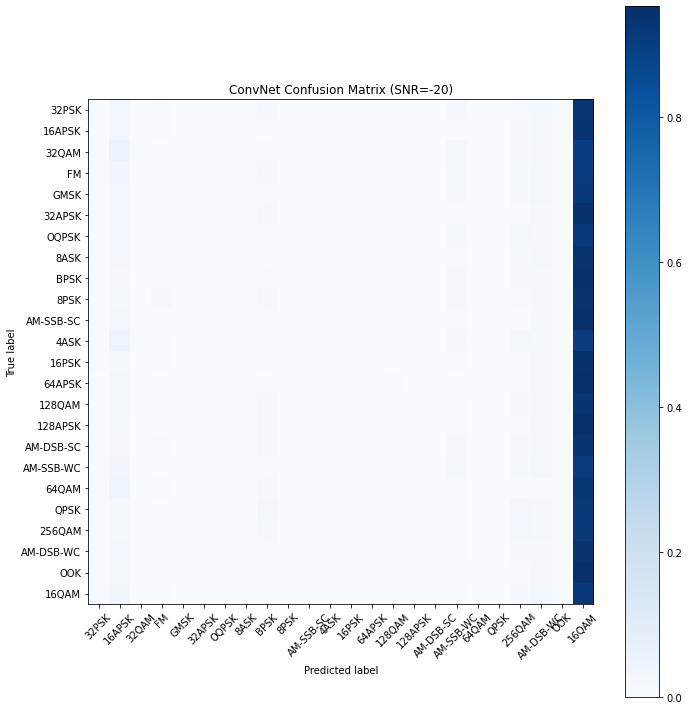

<Figure size 432x288 with 0 Axes>

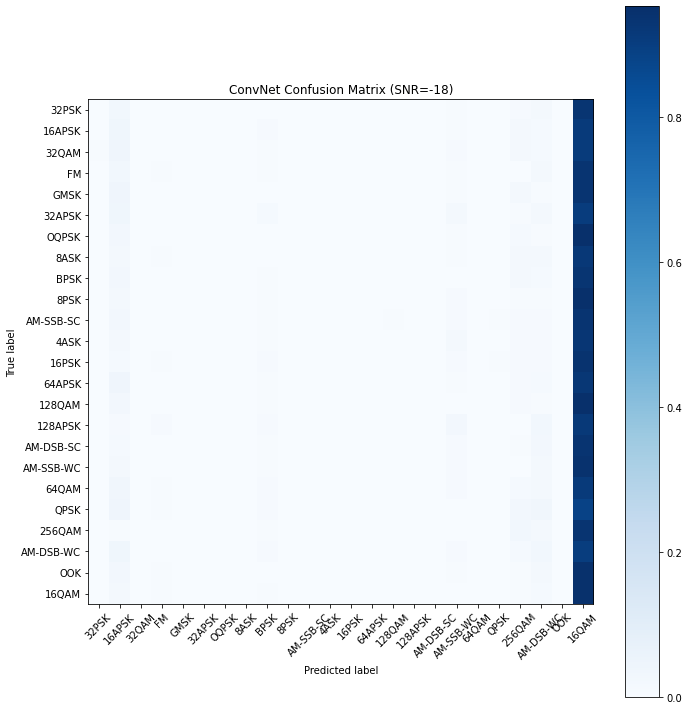

<Figure size 432x288 with 0 Axes>

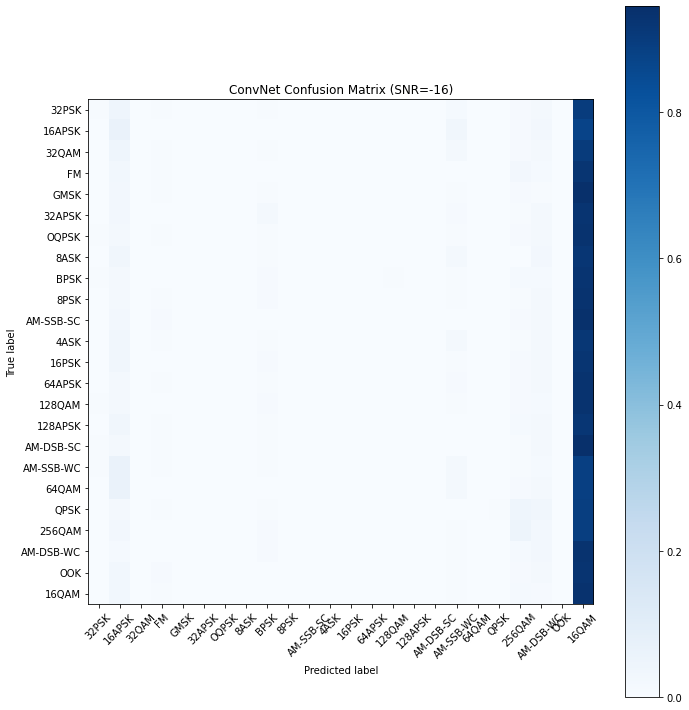

<Figure size 432x288 with 0 Axes>

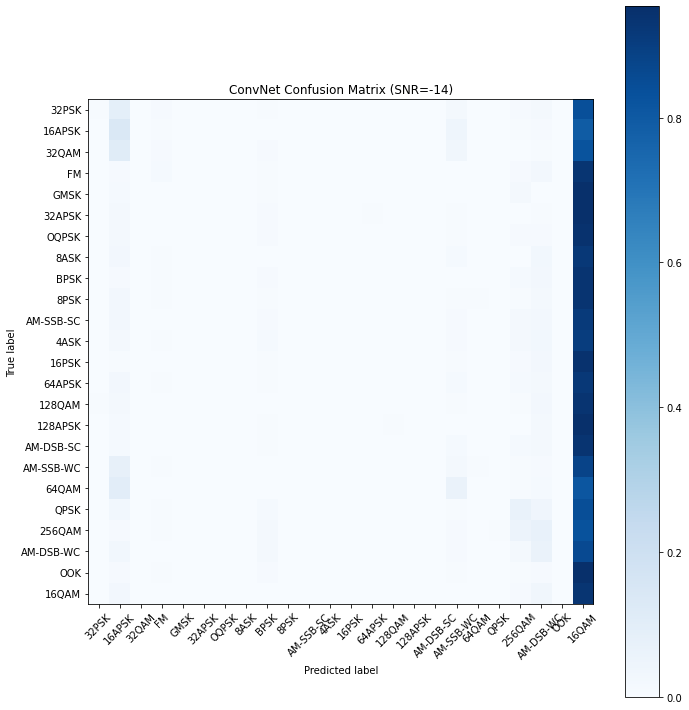

<Figure size 432x288 with 0 Axes>

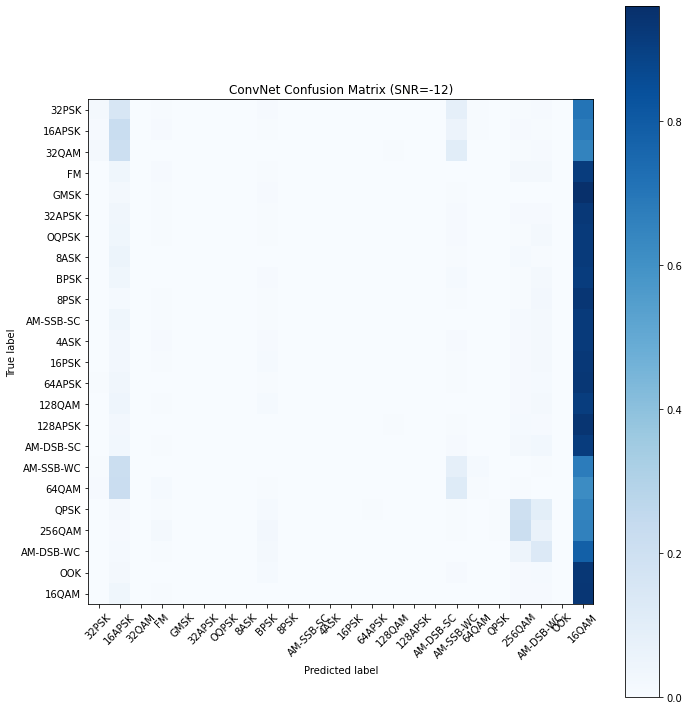

<Figure size 432x288 with 0 Axes>

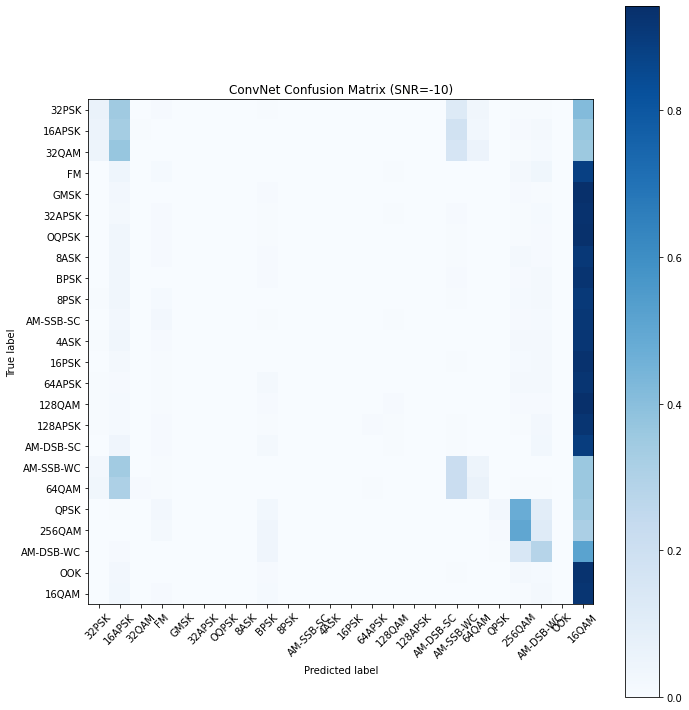

<Figure size 432x288 with 0 Axes>

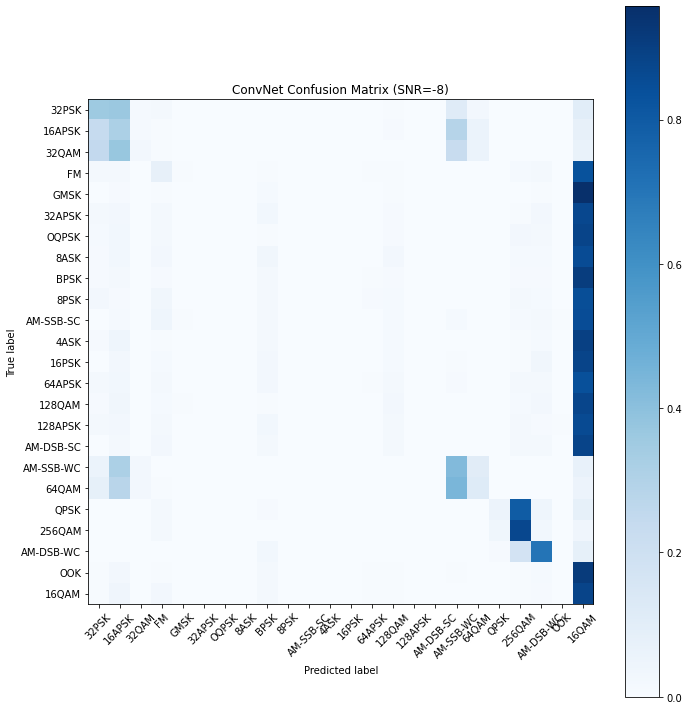

<Figure size 432x288 with 0 Axes>

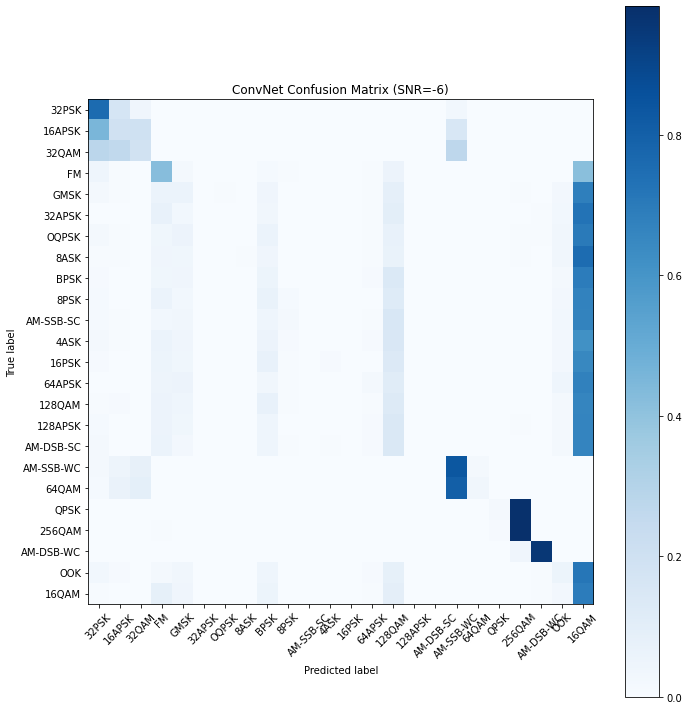

<Figure size 432x288 with 0 Axes>

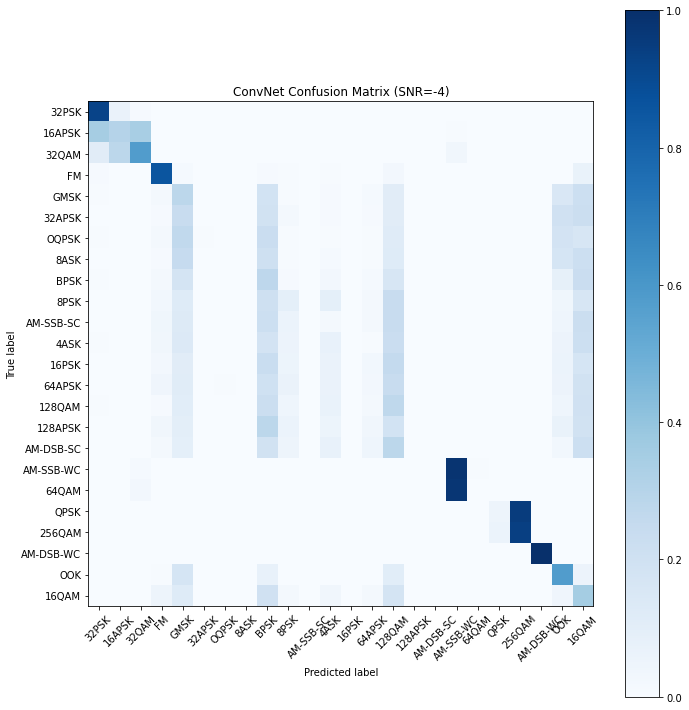

<Figure size 432x288 with 0 Axes>

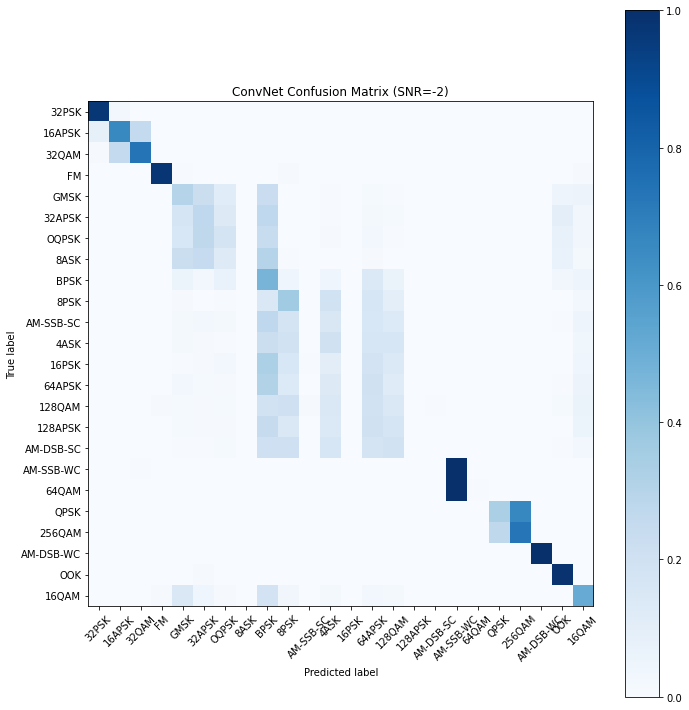

<Figure size 432x288 with 0 Axes>

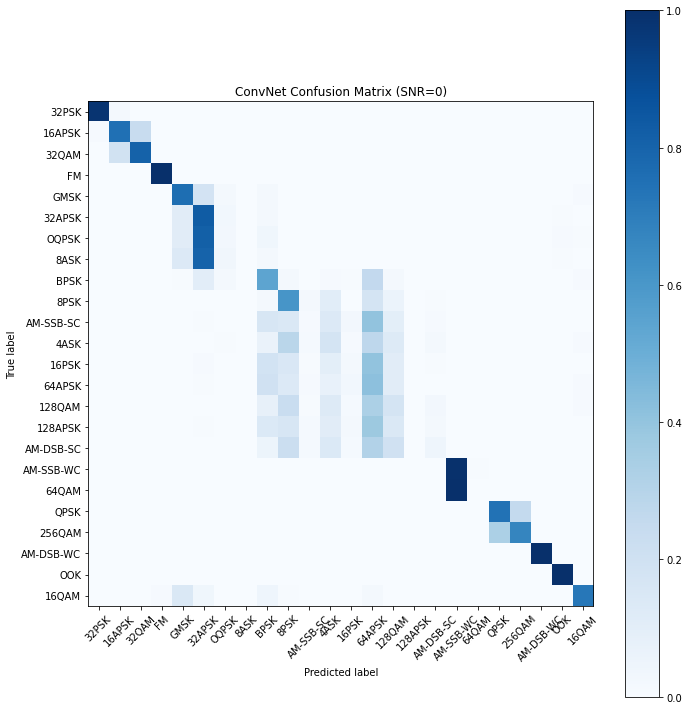

<Figure size 432x288 with 0 Axes>

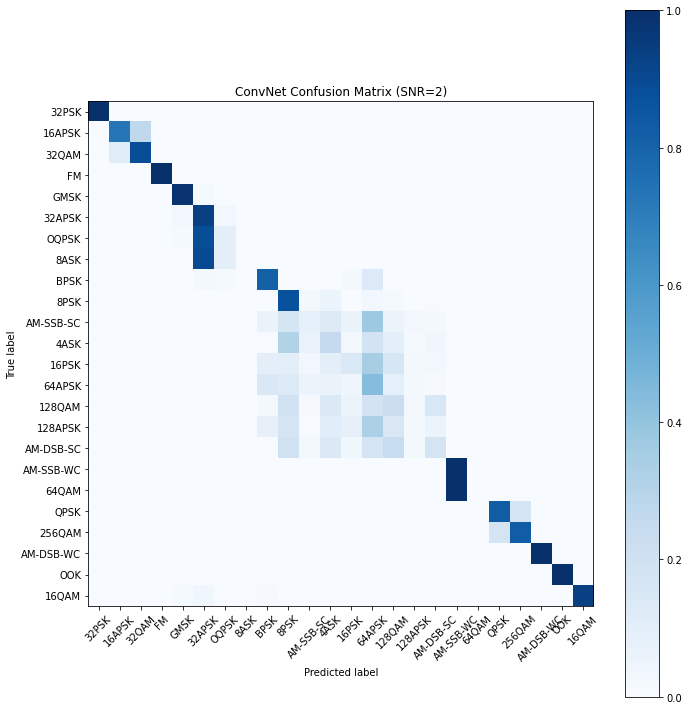

<Figure size 432x288 with 0 Axes>

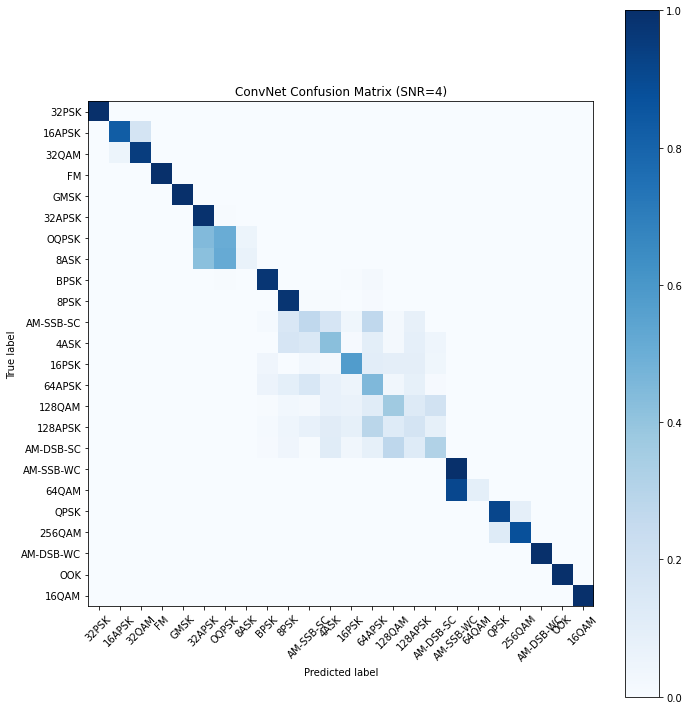

<Figure size 432x288 with 0 Axes>

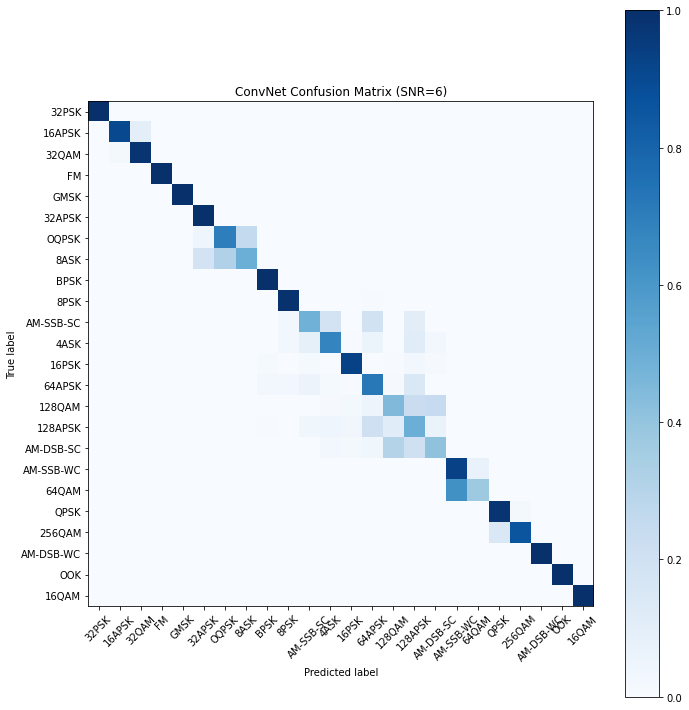

<Figure size 432x288 with 0 Axes>

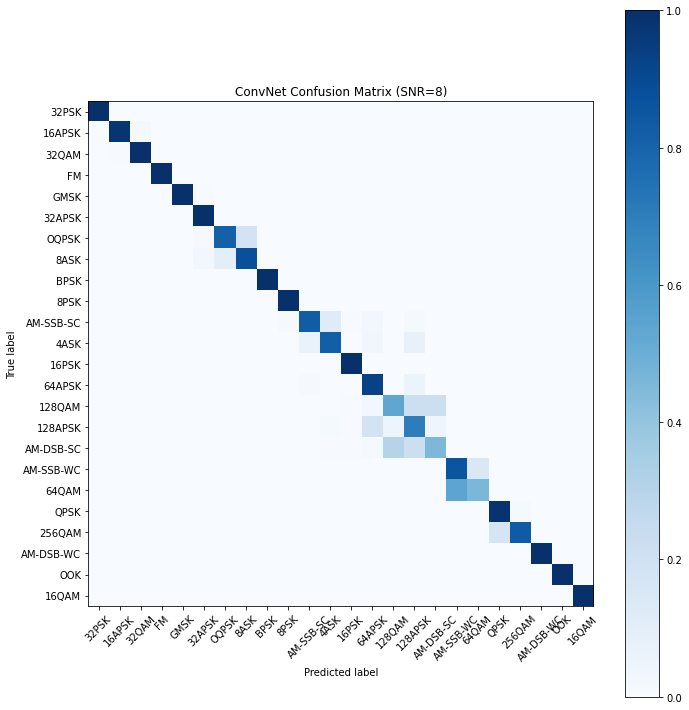

<Figure size 432x288 with 0 Axes>

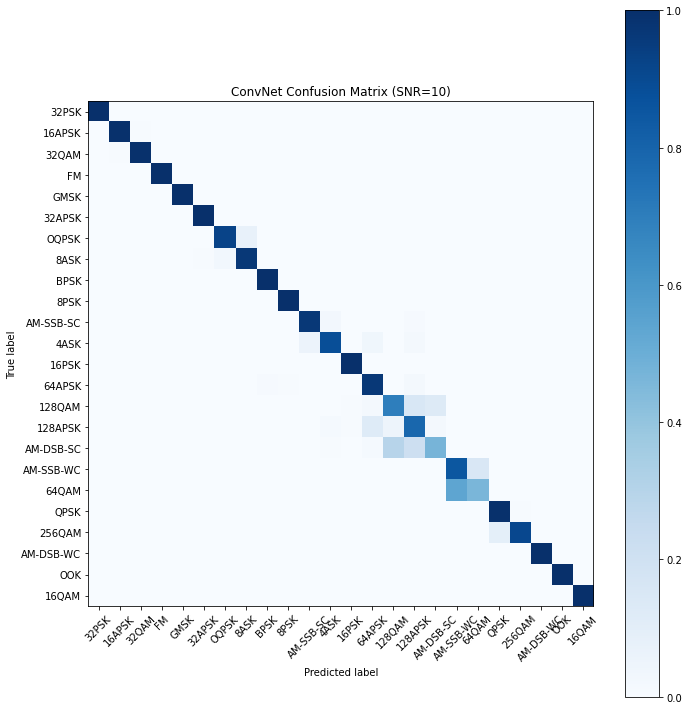

<Figure size 432x288 with 0 Axes>

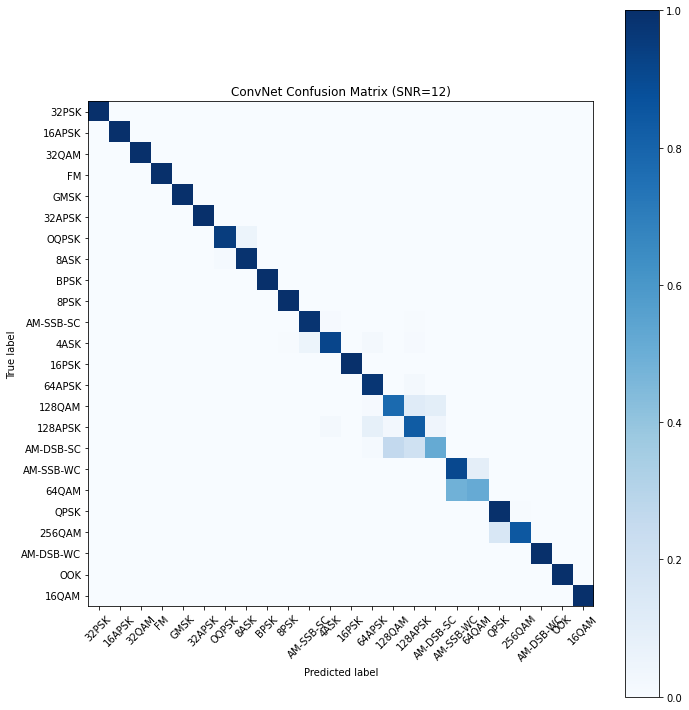

<Figure size 432x288 with 0 Axes>

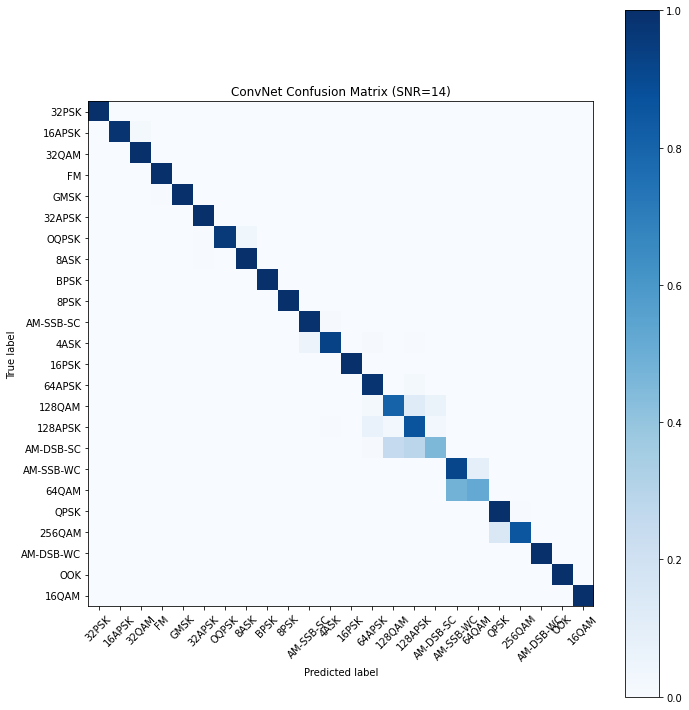

<Figure size 432x288 with 0 Axes>

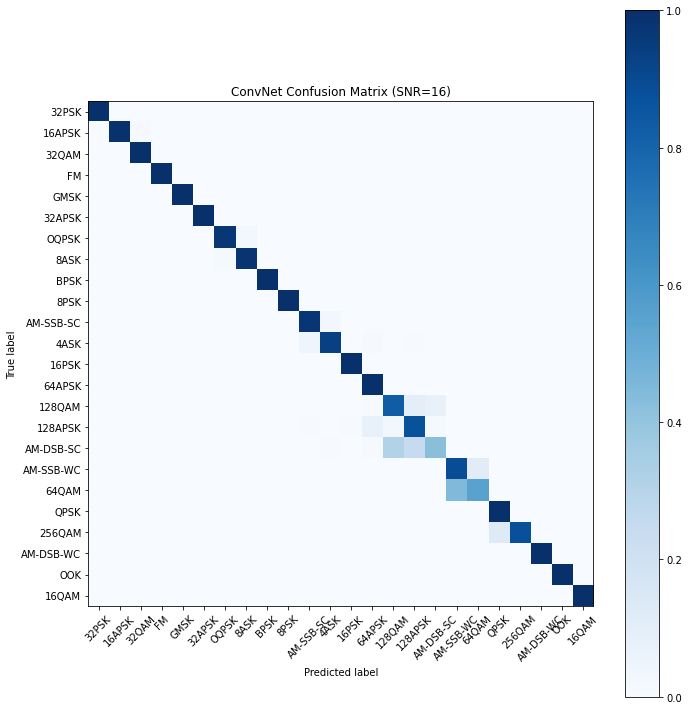

<Figure size 432x288 with 0 Axes>

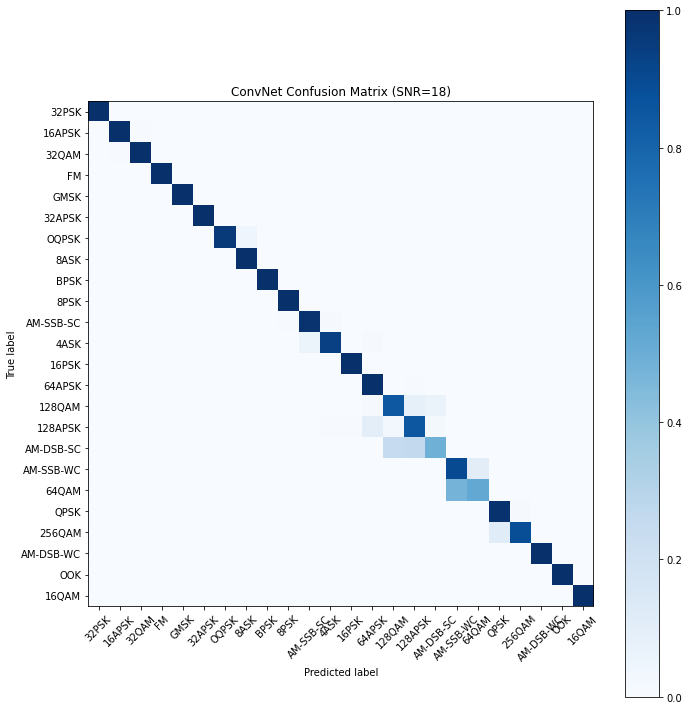

<Figure size 432x288 with 0 Axes>

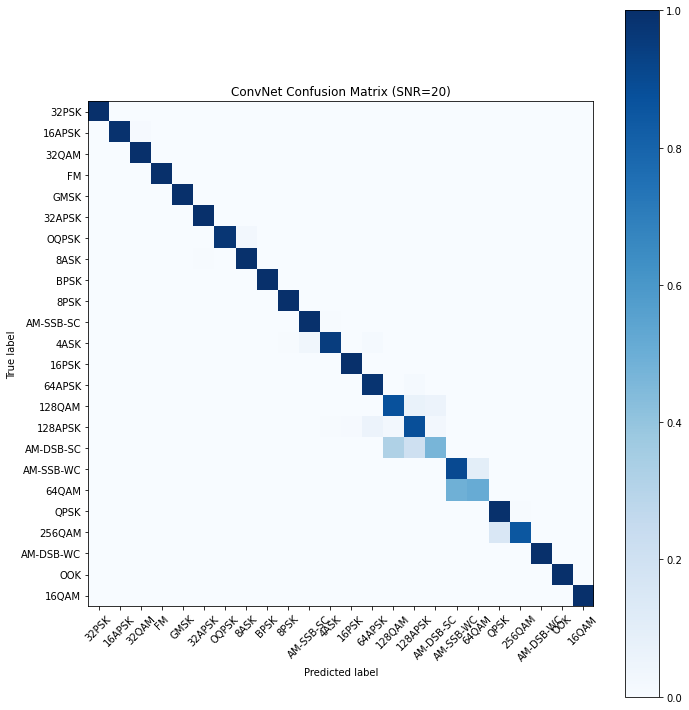

<Figure size 432x288 with 0 Axes>

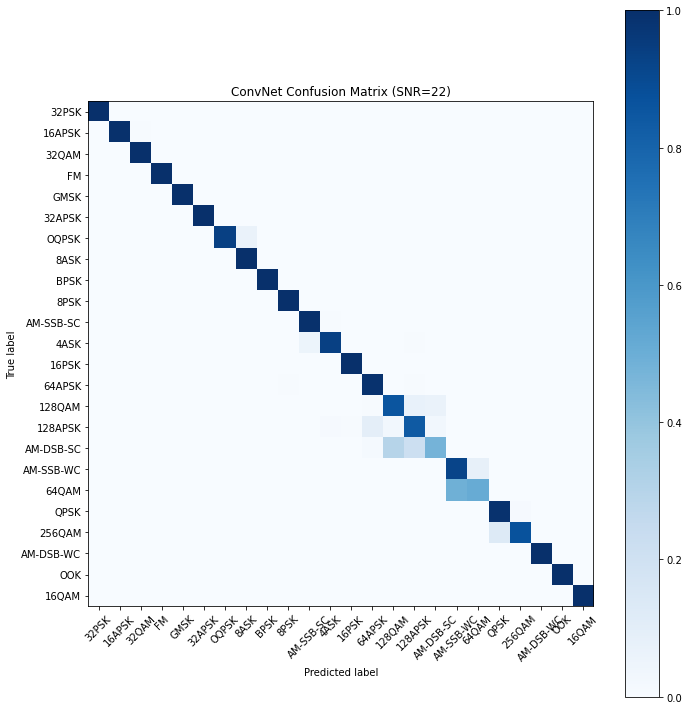

<Figure size 432x288 with 0 Axes>

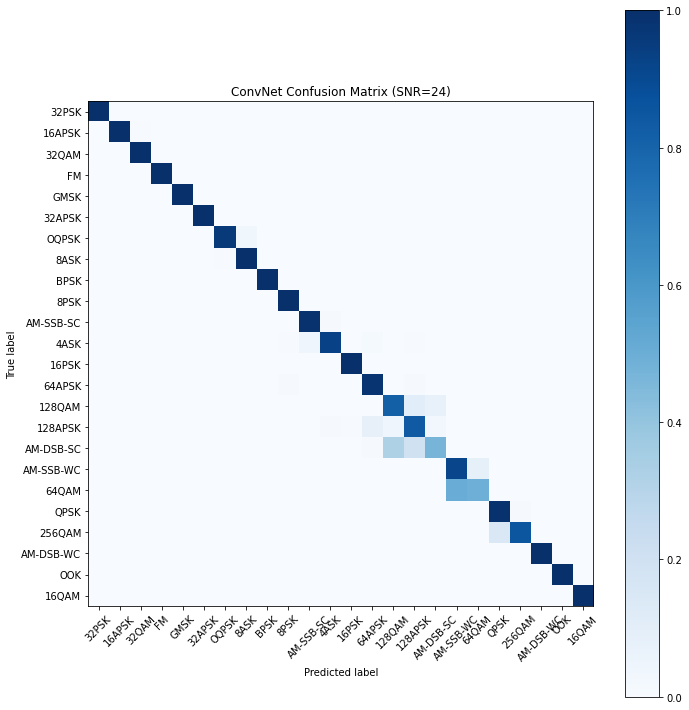

<Figure size 432x288 with 0 Axes>

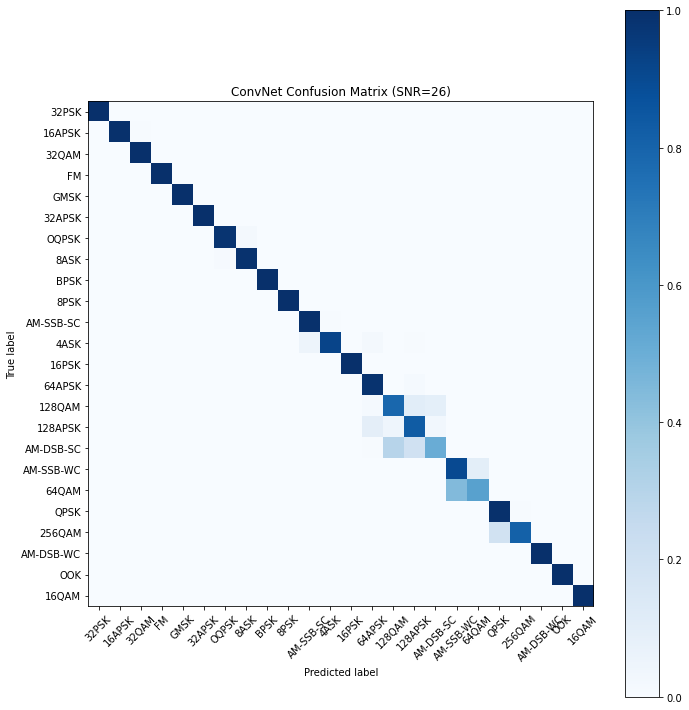

<Figure size 432x288 with 0 Axes>

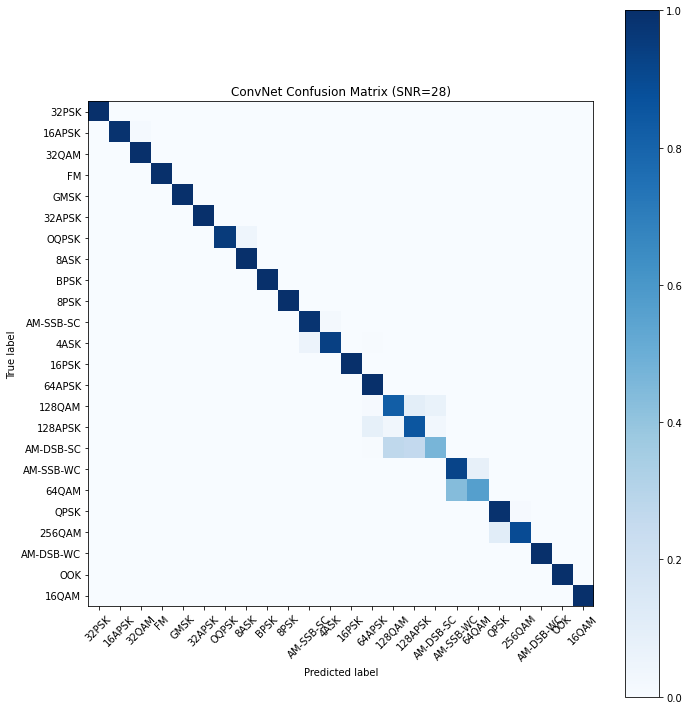

<Figure size 432x288 with 0 Axes>

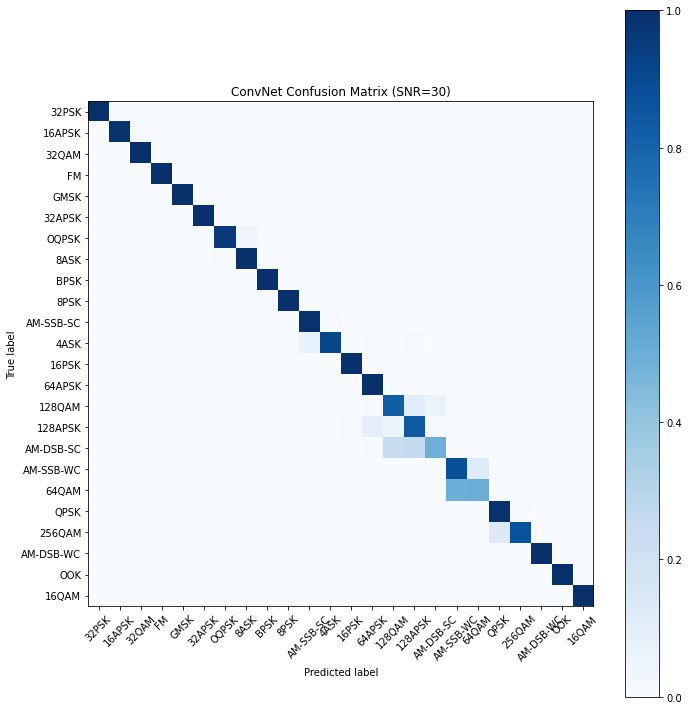

In [80]:

acc={}
Z_test = Z[test_idx]
Z_test = Z_test.reshape((len(Z_test)))
SNRs = np.unique(Z_test)
for snr in SNRs:
    X_test_snr = X_test[Z_test==snr]
    Y_test_snr = Y_test[Z_test==snr]
    
    pre_Y_test = model.predict(X_test_snr)
    conf = np.zeros([len(classes),len(classes)])
    confnorm = np.zeros([len(classes),len(classes)])
    for i in range(0,X_test_snr.shape[0]):    #该信噪比下测试数据量
        j = list(Y_test_snr[i,:]).index(1)   #正确类别下标
        k = int(np.argmax(pre_Y_test[i,:])) #预测类别下标
        conf[j,k] = conf[j,k] + 1
    for i in range(0,len(classes)):
        confnorm[i,:] = conf[i,:] / np.sum(conf[i,:])
   
    plt.figure()
    plot_confusion_matrix(confnorm, labels=classes, title="ConvNet Confusion Matrix (SNR=%d)"%(snr))
    
    cor = np.sum(np.diag(conf))
    ncor = np.sum(conf) - cor
    print ("Overall Accuracy %s: "%snr, cor / (cor+ncor))
    acc[snr] = 1.0*cor/(cor+ncor)

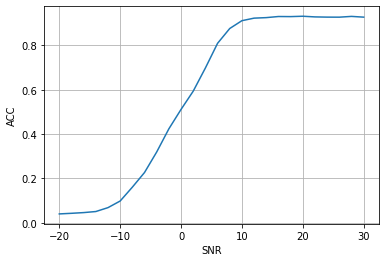

In [82]:

plt.plot(acc.keys(),acc.values())
plt.ylabel('ACC')
plt.xlabel('SNR')
plt.grid(True)
plt.show()